# Data Mining for Security Applications: final project

This final hands on project will count for 50% of your final grade (exam is the other 50%)

## Organization
* you can start the project as of now
* the project has to be handed in no later than March 1st - NO EXTENSIONS!

### Project Submission
* hand in a single jupyter notebook for your project (via moodle)
* set all paths as relative paths such that the data is in the same folder as the notebook
* your notebook should run without errors (uncomment parts that do not work)
* Use markdown cells and comments in the code to document and motivate you solution
* show and analyze intermediate results
* evaluate and discuss your solution

### Grading Criteria
* 4.0 : notebook that works and gives some solution to the problem
* 3.0 : + good documentation, evaluation and discussion
* 2.0 : + complete processing pipeline, good results
* 1.0 : + very detailed documentation and analysis, hyper-parameter optimization, tried and compared more than one method



# Task: Breaking image captchas  

We are working on this Kaggle Challenge: https://www.kaggle.com/fournierp/captcha-version-2-images  

HINT: have a good look at the problem description and the notebooks of other users to get started

* Train and test images are in the according folders
* The true labels are encoded in the file names

## Tasks to follow:
* write code to read the images [use the imageio lib](https://imageio.readthedocs.io/en/stable/userapi.html) and convert then into NUMPY feature vectors
and labels
    * HINT: use [the os lib](https://docs.python.org/2/library/os.html#os.listdir) to get files in a directory
* the hardest part is to solve the segmentation problem: splitting the image into single characters
    * try Clustering over pixel positions
    * or a density projection along the y-axis
* crate a training data set of labeled character segments
    * evaluate this step
* train a CNN or MLP network to classify character segments
    * evaluate this step
* build a full pipeline to transform capcha image inputs into strings
* Evaluate and discuss your results

# **1. Problem Statement & Context**

**About the Dataset & Context:**

CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) images were originally designed in 1997 to distinguish human users from bots (e.g., to prevent spam or DDoS attacks). Although CAPTCHAs have largely been replaced by reCAPTCHA in many applications, they remain an interesting challenge for computer vision.

**Dataset Description:**

The dataset contains noisy CAPTCHA images.
Each image is a 200*50 PNG that displays a 5 character string, where the characters can be letters or numbers.
Noise (e.g., blur and random lines) is deliberately applied, and characters often overlap.

**Problem Statement:**

The task is to automatically recognize the 5 character CAPTCHA images despite high noise levels and overlapping letters. The goal is to build a robust model that directly outputs the entire 5 character string from the whole image without explicitly segmenting individual characters.

# **2. Approach and Why Segmentation Was Abandoned**

Initial Approach – Segmentation:
Initially, I attempted to segment the image into individual characters and then recognize each one. However, due to the significant noise and overlapping of letters, segmentation was unreliable. The letters were not easily separable; the noise and blur caused the segmentation algorithm to mis-identify or merge characters, leading to poor recognition performance.

Here is some examples to segmentation results i got: 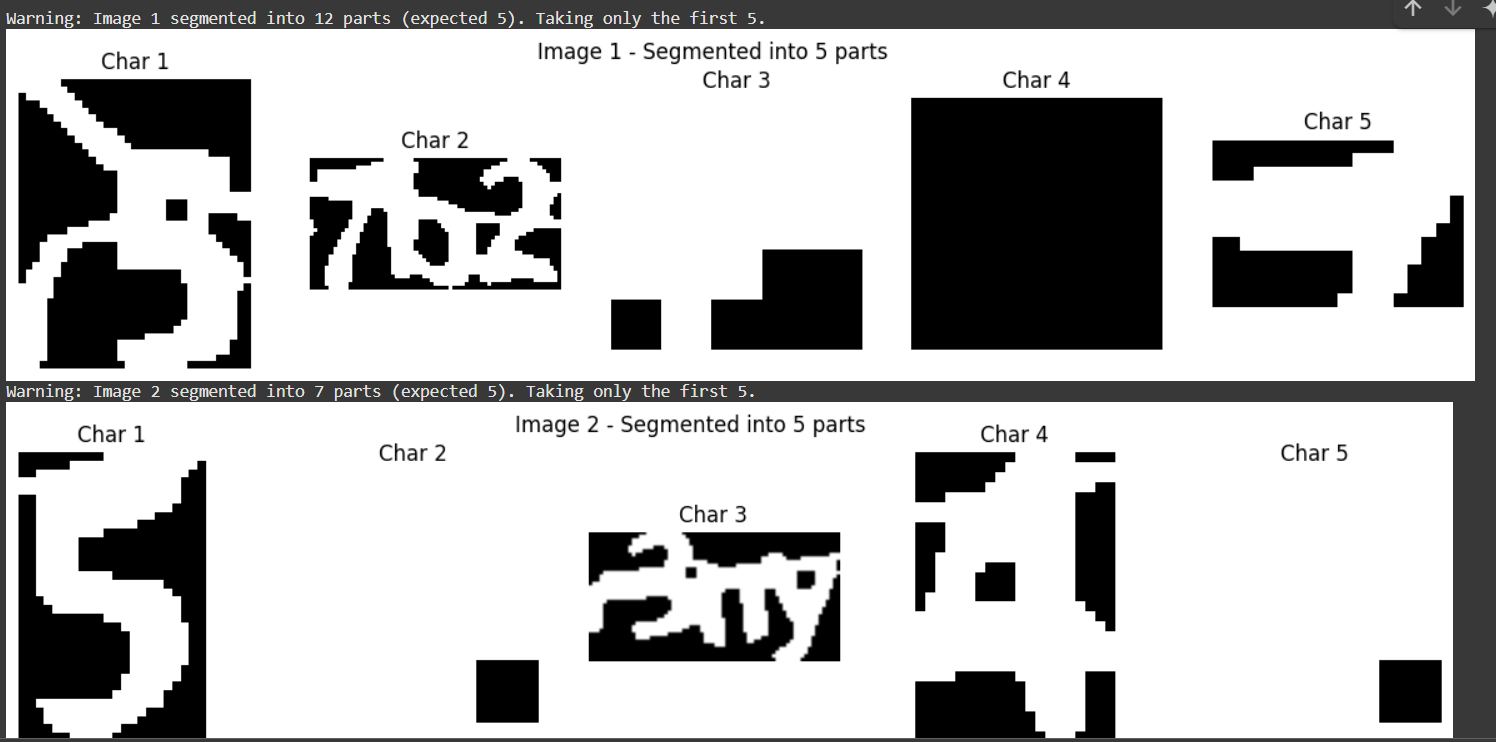

**Chosen Approach – Segmentation-Free Recognition with a CNN:**

Instead of isolating each character, I used a Convolutional Neural Network (CNN) to perform end-to-end recognition. The CNN takes the entire CAPTCHA image as input and directly predicts a sequence of 5 characters in one go. This method is more robust in noisy conditions because:

*   The network learns to extract features that are invariant to noise.
*   It bypasses the unreliable segmentation step.
*   It simultaneously predicts all characters, taking into account contextual information across the entire image.

In [ ]:
!git clone https://github.com/keuperj/ENITS_DataMining_WS24.git

Cloning into 'ENITS_DataMining_WS24'...
remote: Enumerating objects: 1329, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1329 (delta 4), reused 6 (delta 2), pack-reused 1316 (from 2)
Receiving objects: 100% (1329/1329), 22.42 MiB | 17.26 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Updating files: 100% (1329/1329), done.


In [ ]:
!pip install tensorflow

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape


In [ ]:
# -------------------------------------------------------------------
# 1. Define paths and parameters
# -------------------------------------------------------------------

project_path = '/content/ENITS_DataMining_WS24/Project'
train_path = os.path.join(project_path, 'train')
test_path  = os.path.join(project_path, 'test')

# Image dimensions and label settings
img_height = 50
img_width = 200
# Define a full set of possible characters (lowercase letters and digits)
characters = string.ascii_lowercase + string.digits  # 'abcdefghijklmnopqrstuvwxyz0123456789'
print(f"Defined characters set: {characters}")
num_symbols = len(characters)
num_chars = 5                  # Each CAPTCHA has 5 characters

Defined characters set: abcdefghijklmnopqrstuvwxyz0123456789


*   **Image Loading:** The function loads each PNG image in grayscale, resizes it to the desired dimensions, and normalizes pixel values.
*   **Label Extraction & Encoding:** The label is taken from the filename (by removing the .png extension). Each of the 5 characters is one-hot encoded based on the defined character set.
*   **Output:** The function returns NumPy arrays X (images) and y (one-hot encoded labels) for use in model training.

In [ ]:
# -------------------------------------------------------------------
# 2. Data Preprocessing Function
# -------------------------------------------------------------------
def preprocess_data(data_path):
    """
    Loads images and one-hot encodes labels from a given folder.

    Each image is assumed to be in grayscale (or is converted to grayscale)
    and resized to (50, 200). The label is taken from the filename (without extension)
    and must be exactly 5 characters long.

    Returns:
      X: NumPy array of shape (n_samples, 50, 200, 1)
      y: NumPy array of shape (n_samples, 5, num_symbols) with one-hot encoded labels
    """
    # List only PNG files with labels exactly 5 characters long
    files = [f for f in os.listdir(data_path) if f.lower().endswith('.png') and len(f[:-4]) == 5]
    n_samples = len(files)
    X = np.zeros((n_samples, img_height, img_width, 1), dtype=np.float32)
    y = np.zeros((n_samples, num_chars, num_symbols), dtype=np.float32)

    for i, filename in enumerate(files):
        # Read image in grayscale
        img_path = os.path.join(data_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        # Resize if needed
        if img.shape != (img_height, img_width):
            img = cv2.resize(img, (img_width, img_height))
        # Normalize pixel values to [0, 1] and expand dims to (height, width, 1)
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=-1)
        X[i] = img

        # Process label (filename without extension)
        label = filename[:-4]
        # One-hot encode each character
        for j, char in enumerate(label):
            char_index = characters.find(char)
            if char_index != -1:
                y[i, j, char_index] = 1.0

    print(f"Processed {n_samples} images from {data_path}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# Preprocess training and test data
X_train, y_train = preprocess_data(train_path)
X_test, y_test = preprocess_data(test_path)


Processed 942 images from /content/ENITS_DataMining_WS24/Project/train
X shape: (942, 50, 200, 1), y shape: (942, 5, 36)
Processed 98 images from /content/ENITS_DataMining_WS24/Project/test
X shape: (98, 50, 200, 1), y shape: (98, 5, 36)


Random training samples:


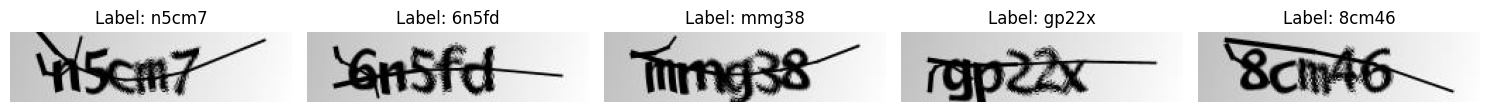

In [ ]:
# -------------------------------------------------------------------
# 3. Visualization Helpers
# -------------------------------------------------------------------
def decode_label(y_onehot, charset=characters):
    """
    Decodes a one-hot encoded label of shape (5, num_symbols) into a string.
    """
    label = ""
    for i in range(y_onehot.shape[0]):
        char_index = np.argmax(y_onehot[i])
        label += charset[char_index]
    return label

# Plot a few random training samples
def plot_random_samples(X, y, num_samples=5):
    indices = random.sample(range(X.shape[0]), num_samples)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        img = X[idx].squeeze()
        label_decoded = decode_label(y[idx])
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label_decoded}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Random training samples:")
plot_random_samples(X_train, y_train, num_samples=5)

# CNN Architecture
**Convolutional Layers:**

1.   Convolutional Layers:


**First Convolution Block:**


* Conv2D Layer:

    Filters: 16

    Kernel Size: 3×3

    Padding: 'same' (ensures the output has the same spatial dimensions as the input)

    Activation: ReLU (introduces non-linearity)

    Input Shape: (50, 200, 1) for grayscale images
*   MaxPooling2D Layer:

    Pool Size: 2×2

    This layer reduces the spatial dimensions (height and width) by a factor of 2, which helps in reducing computational complexity and introduces some translation invariance.

*   Second Convolution Block:
    Another Conv2D layer with the same configuration (16 filters, 3×3 kernel, 'same' padding, ReLU activation) is applied.

    Followed by a MaxPooling2D layer (2×2) that further reduces the spatial dimensions.

**Third Convolution Block:**

* Conv2D Layer:
    Filters: 32
    Kernel Size: 3×3
    Padding: 'same'
    Activation: ReLU
    Followed by a MaxPooling2D layer (2×2).

**Fourth Convolution Block:**

 * Another Conv2D layer with 32 filters, 3×3 kernel, 'same' padding, and ReLU activation.

 * Followed by a MaxPooling2D layer (2×2).

2. Flattening and Fully Connected Layers:

* Flatten Layer:

    This converts the 2D feature maps from the convolutional blocks into a one-dimensional vector, preparing the data for the Dense layers.
* Dropout Layer:

    Rate: 0.5

    This randomly sets 50% of the inputs to zero during training, which helps prevent overfitting by reducing the network’s reliance on any single feature.

* Dense Layer:

    Neurons: 1500

    Activation: ReLU

    Acts as a fully connected layer to learn high-level representations from the extracted features.

* Second Dropout Layer:

    Rate: 0.4

    Further regularizes the model by randomly dropping 40% of the neurons.

3.   Output Layer:

* Dense Layer:

Units:
5
×
num_symbols
5×num_symbols. For instance, if there are 36 possible characters, the dense layer will have
5
×
36
=
180
5×36=180 units.

Activation: Softmax

This layer converts its outputs into probability distributions, with each group of
num_symbols
num_symbols units representing the probabilities for one of the 5 character positions.

* Reshape Layer:

This layer reshapes the dense layer’s flat output vector (of length
5
×
num_symbols
5×num_symbols) into a 2D matrix with shape
(
5
,
num_symbols
)
(5,num_symbols).

Each of the 5 rows corresponds to a single character in the CAPTCHA, and each row contains a probability distribution over all possible characters.

# Regularization

* Dropout Layers:

    Dropout is applied after the flattening layer and after the first Dense layer.

    By randomly setting a fraction of the input units to zero during training, dropout prevents the model from overfitting by forcing it to learn more robust features that are not overly dependent on any one node.

# Model Compilation

* Optimizer:

    Adam:
    An adaptive learning rate optimizer that adjusts the learning rate during training. Adam is popular due to its efficiency and ability to handle sparse gradients.

* Loss Function:

    Categorical Crossentropy:
    Used because each character is predicted as one of many classes (via one-hot encoding).

    This loss function calculates the difference between the predicted probability distribution and the true distribution (the one-hot encoded label) for each character.
* Metrics:

    Accuracy:
    Monitors the fraction of correctly predicted characters (or entire sequences, depending on how accuracy is computed in your multi-output setting).

In [ ]:
# -------------------------------------------------------------------
# 4. Build the CNN Model
# -------------------------------------------------------------------
model = Sequential([
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(1500, activation='relu'),
    Dropout(0.4),
    Dense(num_chars * num_symbols, activation='softmax'),
    Reshape((num_chars, num_symbols))
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 50, 200, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 100, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 25, 100, 16)         │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 50, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 50, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 25, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 25, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 12, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1500)                │       1,729,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1500)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 180)                 │         270,180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 5, 36)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,016,048 (7.69 MB)

 Trainable params: 2,016,048 (7.69 MB)

 Non-trainable params: 0 (0.00 B)

**Augmentation Function:** The augment function applies random brightness and contrast changes to simulate variations in the data.
* Purpose:

    Simulate Variability: These adjustments simulate different lighting conditions and contrast variations that may occur in real-world scenarios.

    Increase Robustness: By exposing the model to these variations during training, the model becomes more robust and is better able to generalize to unseen data, even if the images have different brightness or contrast levels.

**Dataset Creation:** The training dataset is built with the tf.data API, applying augmentation, shuffling, batching, and repeating.
* Purpose:

    Efficient Data Handling: The tf.data API efficiently pipelines data, enabling high-performance training.

    Enhanced Model Generalization: Shuffling and augmentation help the model avoid overfitting by ensuring that each batch is varied and representative of different possible conditions.

    Seamless Training: Batching and repeating allow the model to continuously receive data during the training process, which is especially useful for large datasets.

**Visualization:** A helper function visualizes a few augmented images to verify that the augmentations are working as expected.

In [ ]:
# -------------------------------------------------------------------
# 5. Data Augmentation and tf.data Datasets
# -------------------------------------------------------------------
def augment(image, label):
    """
    Apply simple augmentations: random brightness and contrast.
    """
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

batch_size = 64

# Create training dataset with augmentation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), y))
train_dataset = train_dataset.map(augment)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).repeat()

steps_per_epoch = np.ceil(len(X_train) / batch_size).astype(int)

# Create validation dataset (no augmentation needed)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

Augmented training samples:


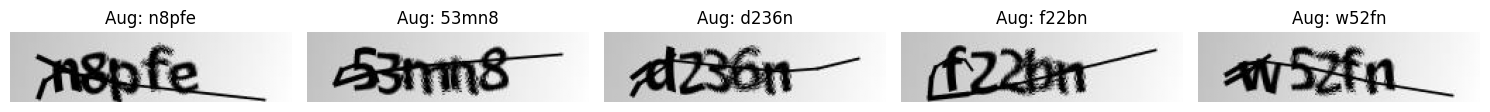

In [ ]:
# Visualize some augmented images from the training set
def plot_augmented_samples(dataset, num_samples=5):
    # Get one batch from the dataset
    batch = next(iter(dataset))
    images, labels = batch
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img = images[i].numpy().squeeze()
        label_decoded = decode_label(labels[i].numpy())
        plt.imshow(img, cmap='gray')
        plt.title(f"Aug: {label_decoded}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Augmented training samples:")
plot_augmented_samples(train_dataset, num_samples=5)


**Callbacks:**

**EarlyStopping:**

Monitors the validation loss during training and stops the training process if the loss does not improve for a specified number of epochs (in this case, 10 epochs).

* Purpose:
    Prevents Overfitting: Halts training before the model starts overfitting to the training data.

    Saves Time: Avoids unnecessary training once the model performance on validation data plateaus.

**ReduceLROnPlateau:**

Monitors the validation loss and reduces the learning rate by a factor (here, 0.5) if the loss does not improve for a given number of epochs (patience of 5 epochs).
* Purpose:
    Adaptive Learning Rate: Helps the model converge more smoothly by lowering the learning rate when progress stalls, allowing for finer adjustments to the weights.

    Avoids Local Minima: Can help escape plateaus and find a better minimum in the loss landscape.

**ModelCheckpoint:**

Saves the best model (using the new Keras format, e.g., 'best_model.keras') based on the lowest validation loss observed during training.
* Purpose:
    Preserve the Best Model: Ensures that the optimal weights are saved for later use, even if later training epochs do not yield improvements.

    Easy Model Recovery: Allows for restoring the best-performing model for further evaluation or deployment.

**Training with Callbacks:**

The model is trained on the augmented training dataset while these callbacks monitor performance, adjust training parameters, and save the best model.
* Purpose:
    Optimized Training Process: The combination of callbacks ensures that training is efficient and that the model generalizes well by preventing overfitting and adapting the learning rate dynamically.
    
    Record Keeping: Training history is recorded for later analysis, allowing you to visualize loss and accuracy trends over time and make informed decisions about further model improvements.


In [ ]:
# -------------------------------------------------------------------
# 6. Define Callbacks and Train the Model
# -------------------------------------------------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 602ms/step - accuracy: 0.0640 - loss: 3.3552 - val_accuracy: 0.0653 - val_loss: 3.0142 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 492ms/step - accuracy: 0.0728 - loss: 2.9989 - val_accuracy: 0.0878 - val_loss: 2.9642 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 503ms/step - accuracy: 0.1016 - loss: 2.9424 - val_accuracy: 0.0878 - val_loss: 2.9464 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 532ms/step - accuracy: 0.1049 - loss: 2.9216 - val_accuracy: 0.0878 - val_loss: 2.9414 - learning_rate: 0.0010
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 448ms/step - accuracy: 0.1013 - loss: 2.8977 - val_accuracy: 0.1000 - val_loss: 2.8756 - learning_rate: 0.0010
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 615ms/step - accuracy: 0.1309 - loss: 2.8276 - val_accuracy: 0.2041 - val_loss: 2.6723 - learning_rate: 0.0010
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 462ms/step - accuracy: 0.2416 - loss: 2

* Visualization of Training Metrics: This function plots the training and validation loss and accuracy over epochs.

* Purpose: These plots help monitor the training process, diagnose potential overfitting, and assess model convergence.

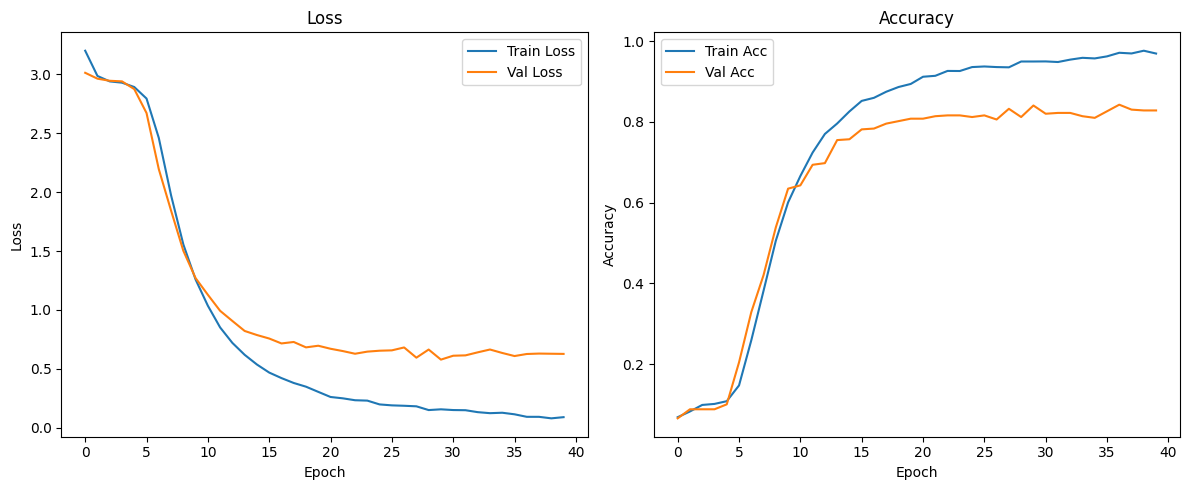

In [ ]:
# -------------------------------------------------------------------
# 7. Plot Training History
# -------------------------------------------------------------------
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Test Accuracy: 0.8408164381980896
Sample predictions on test data:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


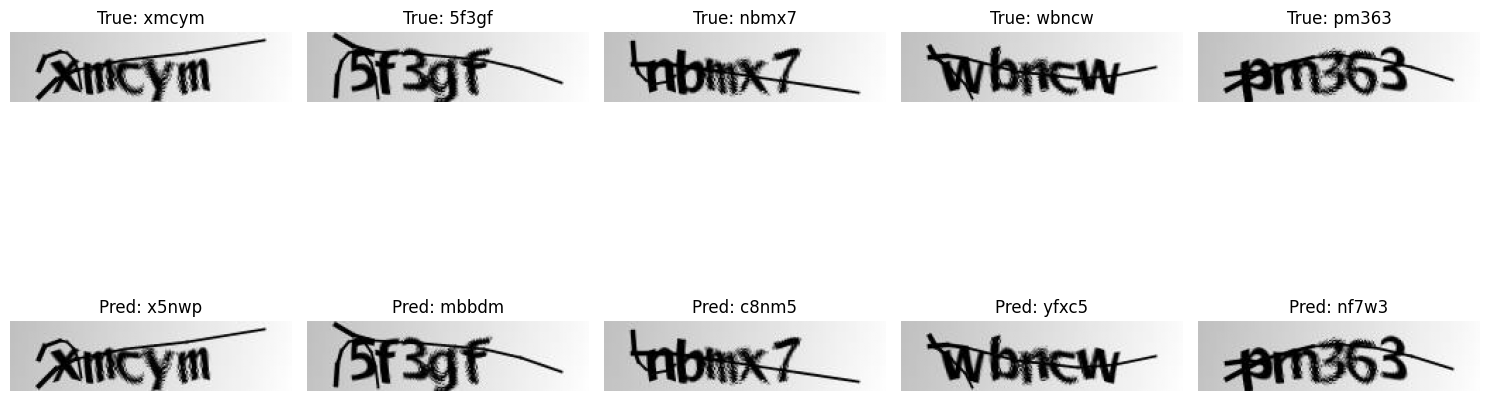

In [ ]:
# -------------------------------------------------------------------
# 8. Evaluate and Visualize Predictions on Test Data
# -------------------------------------------------------------------
loss, acc = model.evaluate(val_dataset, verbose=0)
print('Test Accuracy:', acc)

# Display sample predictions
def plot_predictions(model, X, y, num_samples=5):
    indices = random.sample(range(X.shape[0]), num_samples)
    X_sample = X[indices]
    y_true = y[indices]
    # Predict returns a list of outputs, one per character.
    y_pred_list = model.predict(X_sample)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(indices):
        # Display image
        plt.subplot(2, num_samples, i+1)
        plt.imshow(X[idx].squeeze(), cmap='gray')
        true_label = decode_label(y[idx])
        plt.title(f"True: {true_label}")
        plt.axis('off')

        # Build predicted label by taking argmax for each output
        pred_label = ""
        for k in range(num_chars):
            pred_char = characters[np.argmax(y_pred_list[k][i])]
            pred_label += pred_char
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(X[idx].squeeze(), cmap='gray')
        plt.title(f"Pred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("Sample predictions on test data:")
plot_predictions(model, X_test, y_test, num_samples=5)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
F1 Score (macro): 0.8445185355677612
Correlation Matrix (True positions as rows, Predicted positions as columns):
[[ 0.99074105 -0.33515646 -0.21503     0.00414041 -0.03041291]
 [-0.34204517  0.81370965  0.0995603  -0.01105896  0.00959652]
 [-0.19460908  0.06886528  0.89125705  0.01321311 -0.00225653]
 [ 0.00673993  0.10476889  0.07531327  0.85237117  0.03893157]
 [-0.03367683 -0.04448127 -0.01862864 -0.01666111  0.93198934]]


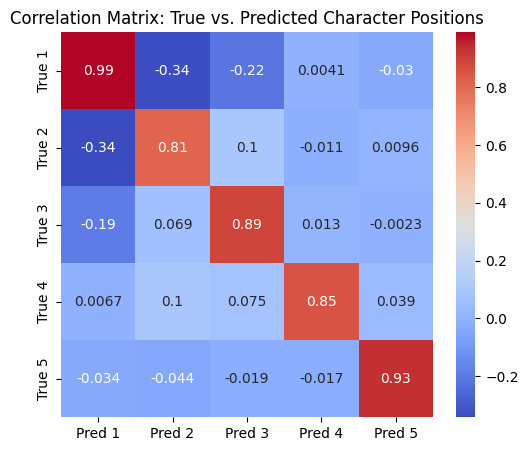

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions on the test set
# y_pred will have shape (n_samples, num_chars, num_symbols)
y_pred = model.predict(X_test)

# Convert one-hot encoded outputs to integer labels (for each character)
# Ground truth: shape (n_samples, num_chars)
y_true_indices = np.argmax(y_test, axis=2)
y_pred_indices = np.argmax(y_pred, axis=2)

# Flatten the arrays to compute a single macro F1 score across all characters
y_true_flat = y_true_indices.flatten()
y_pred_flat = y_pred_indices.flatten()

# Calculate macro F1 score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print("F1 Score (macro):", f1)

# Compute correlation matrix between true and predicted labels for each character position
num_chars = y_true_indices.shape[1]
corr_matrix = np.zeros((num_chars, num_chars))

for i in range(num_chars):
    for j in range(num_chars):
        # Compute Pearson correlation between true labels of position i and predicted labels of position j
        corr_matrix[i, j] = np.corrcoef(y_true_indices[:, i], y_pred_indices[:, j])[0, 1]

print("Correlation Matrix (True positions as rows, Predicted positions as columns):")
print(corr_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
            xticklabels=[f"Pred {i+1}" for i in range(num_chars)],
            yticklabels=[f"True {i+1}" for i in range(num_chars)])
plt.title("Correlation Matrix: True vs. Predicted Character Positions")
plt.show()
